# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '../../')

In [3]:
from src.serve import *

Failed to load FluidSynth. Must install if you want to convert to wav files.


In [4]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [5]:
bs=16
bptt=256

In [6]:
data_dir = 'data/midi/v10/'
source_dir = 'midi_encode'

file_path = Path('../../')
path = file_path/data_dir/source_dir
out_path = file_path/'data/generated/'

In [23]:
config = v10_small_config(vocab_path=path/'tmp/all'); config

{'ctx_len': 150,
 'n_layers': 12,
 'n_heads': 6,
 'd_model': 1024,
 'd_head': 48,
 'd_inner': 512,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'emb_map': [(0, 262, 64)],
 'idx_map': {0: (0, 262, 64)},
 'loss_weights': [1, 1],
 'pad_idx': 0,
 'bos_idx': 2,
 'sep_idx': 1,
 'enc_offset': 3,
 'transpose_range': (0, 24),
 'mask_type': <MaskType.RandomWindow: 3>,
 'bs': 16,
 'bptt': 256,
 'single_stream': True}

In [24]:
data = load_data(path=path, cache_name='tmp/hook', **config)

In [25]:
saved_models = get_files(path/'models/single', recurse=True); saved_models

[PosixPath('../../data/midi/v10/midi_encode/models/single/small/hook_c/1_ep24.pth')]

In [26]:
load_path = saved_models[0]

In [27]:
learn = load_learner(data, config, load_path)

Sep_idx: 1


In [28]:
# htlist = get_htlist(path, source_dir)

### From batch

In [13]:
xb,yb = learn.data.one_batch(cpu=False)

### From song

In [14]:

csv_path = path/f'{source_dir}.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

/Users/andrewshaw/miniconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('flows')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'musescore']; results.head()

,ht_bpm,md5,numpy,ht_time_signature,midi_title,source,artist,ht_offset,section,song_url,mxl,ht_key,parts,title,genres,midi,ht_mode
56458,NaN,6b9ca5372ccc88e8091d40f295d57f27,midi_encode/musescore/data/4272456.npy,NaN,NaN,musescore,ArnavAmit,NaN,NaN,NaN,midi_sources/musescore/data/4272456.mxl,NaN,NaN,River flows in you,"classical,pop,inferred",NaN,NaN
59842,NaN,c6e9d95919225f8d643c4e9332fcd1c4,midi_encode/musescore/data/4743256.npy,NaN,NaN,musescore,Christian Pich von Lipinski,NaN,NaN,NaN,midi_sources/musescore/data/4743256.mxl,NaN,NaN,River flows in you (easy arrangement),"classical,pop,inferred",NaN,NaN
60321,NaN,d923b7a1b02c90f22b07817a268d8860,midi_encode/musescore/data/4965414.npy,NaN,NaN,musescore,Rea H,NaN,NaN,NaN,midi_sources/musescore/data/4965414.mxl,NaN,NaN,River flows in you - piano,"classical,pop,inferred",NaN,NaN


In [16]:
file = file_path/data_dir/results.numpy.values[0]; file

PosixPath('../../data/midi/v10/midi_encode/musescore/data/4272456.npy')

In [17]:
# file = np.random.choice(files)

In [18]:
#good_one = Path('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/c/cool-and-new-web-comic/tick---tock/chorus.npy')
# file = Path('../../data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy')
# third_eye = Path('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/semi-charmed-life/chorus.npy')

In [19]:
seed_len = 140
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(to_single_stream(seed_np))[None]
if torch.cuda.is_available(): xb = xb.cuda()

### Predict

In [147]:
# res1 = torch.randint(0, 1000, (10,10)).float(); res1

# res2 = res1.pow(1 / 10)
# res2 = res2 / res2.sum()
# (res2*1000).round()/1000

# resd5 = res1.pow(1 / .5)
# resd5_prob = resd5 / resd5.sum()
# (resd5_prob*1000).round()/1000

In [148]:
# out, seed = learn.predict(xb, n_words=340, temperature=1, min_p=0.01)

In [149]:
# Higher temperature = More randomness (1.5)
# Lower temperature = Less random (.5)

## Learn predict

In [29]:
out_s, seed_s = learn.predict(xb, n_words=800, temperatures=(1.0,.5), min_ps=(1/128,0.0))
out = to_double_stream(out_s)
seed = to_double_stream(seed_s)

Sep count 1
Sep count 2
Sep count 3
Sep count 4
Sep count 5
Sep count 6
Sep count 7
Sep count 8
Sep count 9
Sep count 10
Sep count 11
Sep count 12
Sep count 13
Sep count 14
Sep count 15
Sep count 16
Sep count 17
Sep count 18
Sep count 19
Sep count 20
Sep count 21
Sep count 22
Sep count 23
Sep count 24
Sep count 25
Sep count 26
Sep count 27
Sep count 28
Sep count 29
Sep count 30
Sep count 31
Sep count 32
Sep count 33
Sep count 34
Sep count 35
Sep count 36
Sep count 37
Sep count 38
Sep count 39
Sep count 40
Sep count 41
Sep count 42
Sep count 43
Sep count 44
Sep count 45
Sep count 46
Sep count 47
Sep count 48
Sep count 49
Sep count 50
Sep count 51
Sep count 52
Sep count 53
Sep count 54
Sep count 55
Sep count 56
Sep count 57
Sep count 58
Sep count 59
Sep count 60
Sep count 61
Sep count 62
Sep count 63
Sep count 64
Sep count 65
Sep count 66
Sep count 67
Sep count 68
Sep count 69
Sep count 70
Sep count 71
Sep count 72
Sep count 73
Sep count 74
Sep count 75
Sep count 76
Sep count 77
Sep coun

### Actual prediction

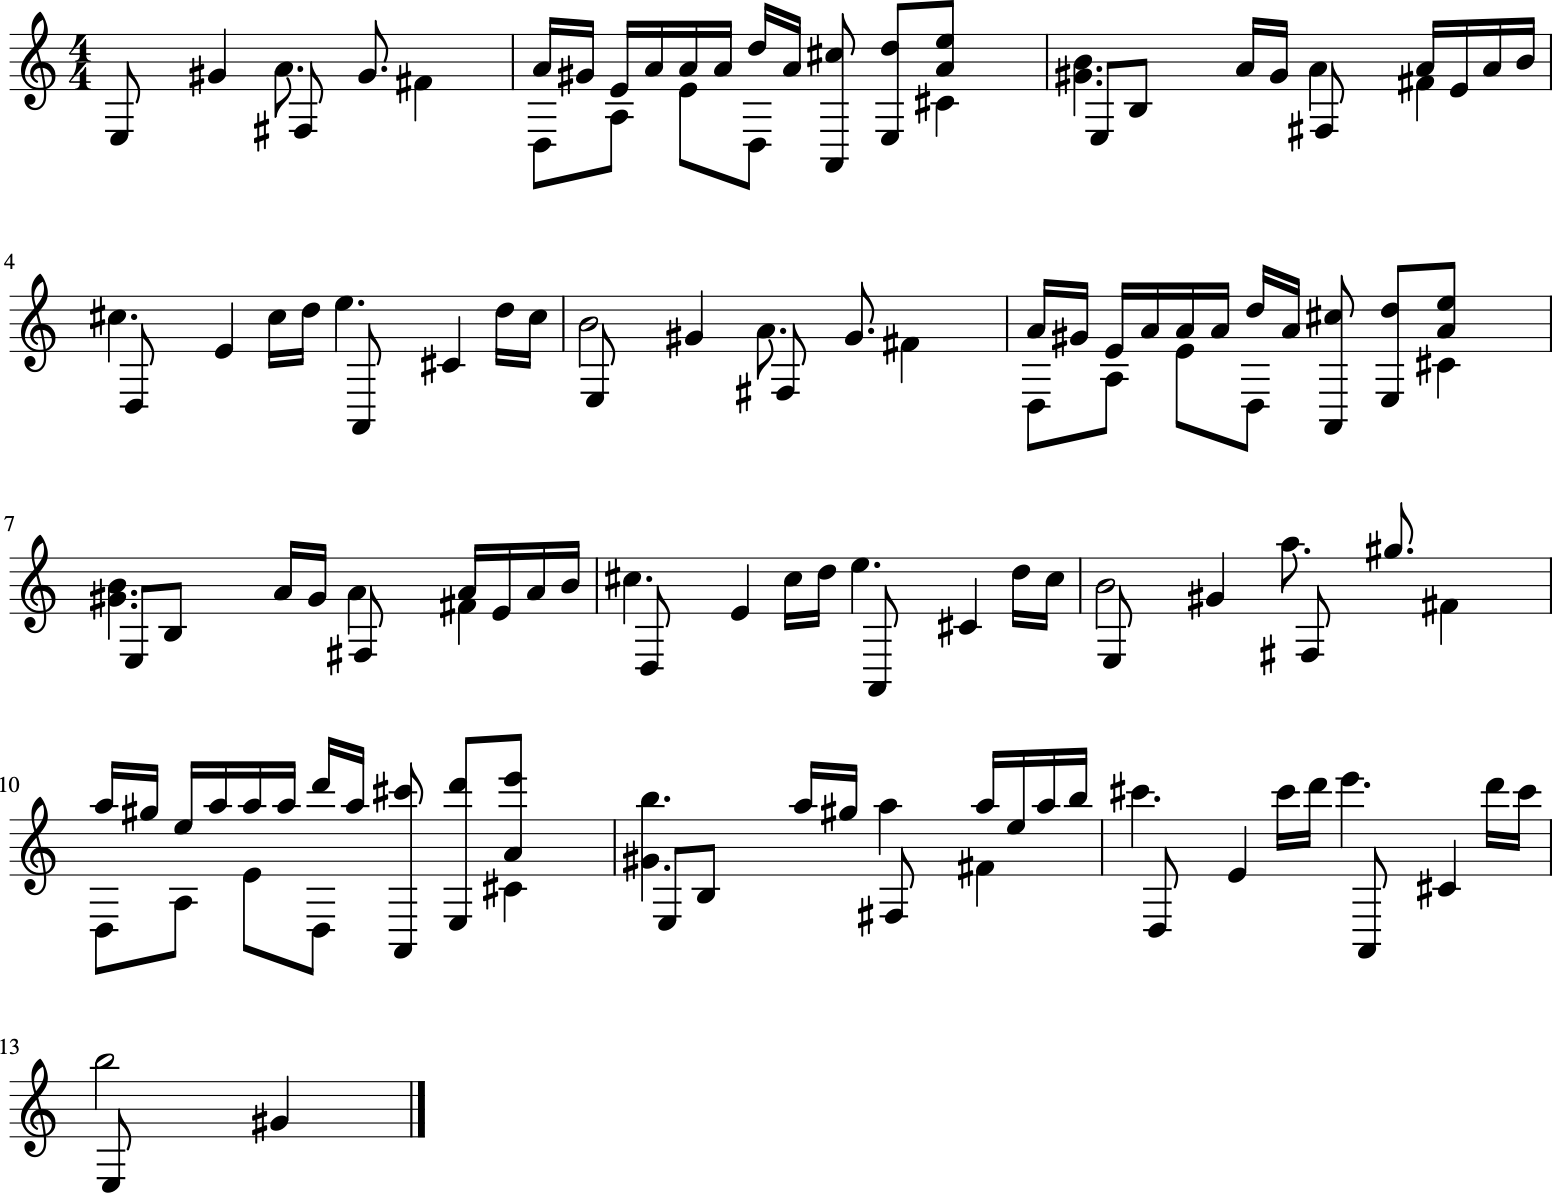

In [30]:
stream = npenc2stream(out)
stream.show()

In [31]:
stream.show('midi')

## Seed

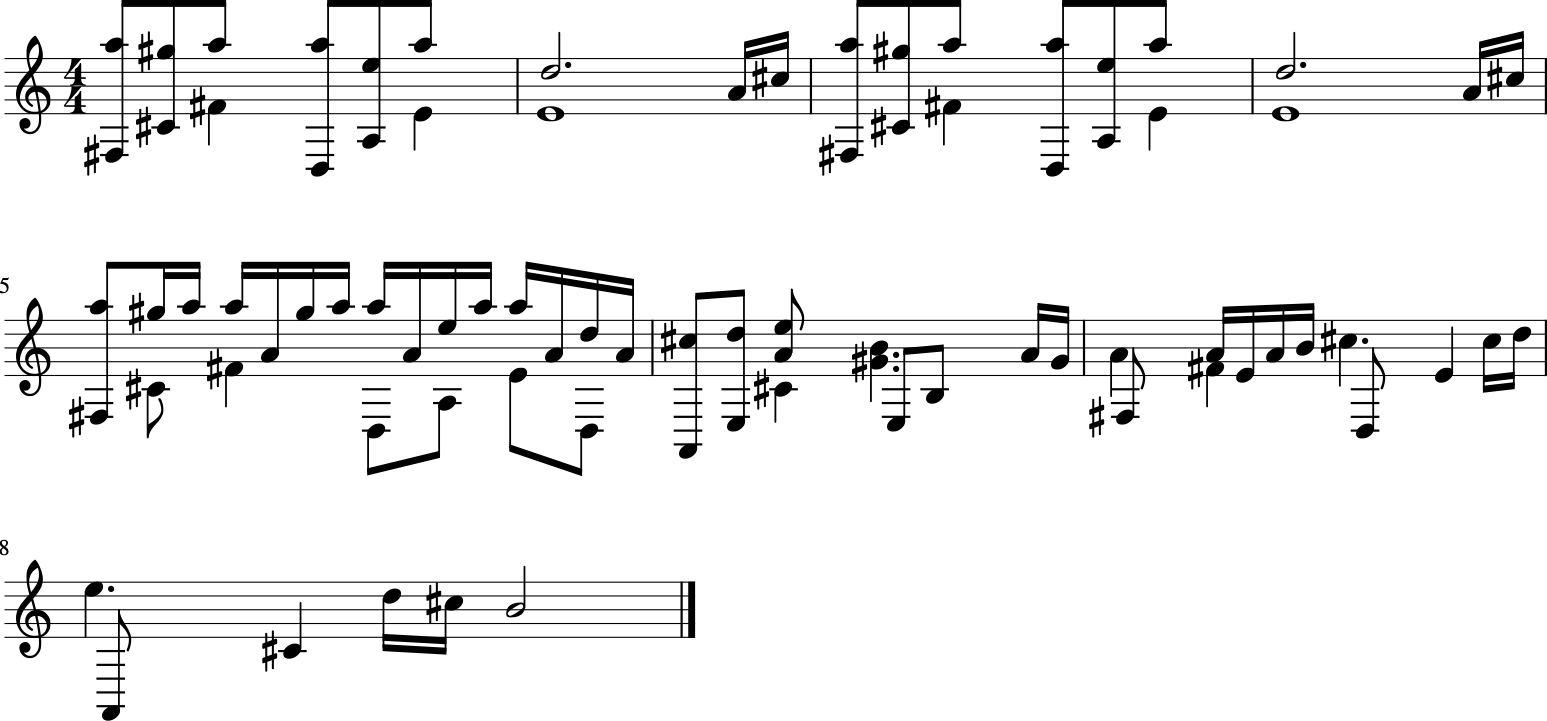

In [32]:
seed_stream = npenc2stream(seed)
seed_stream.show()

In [33]:
seed_stream.show('midi')

## Alltogether now

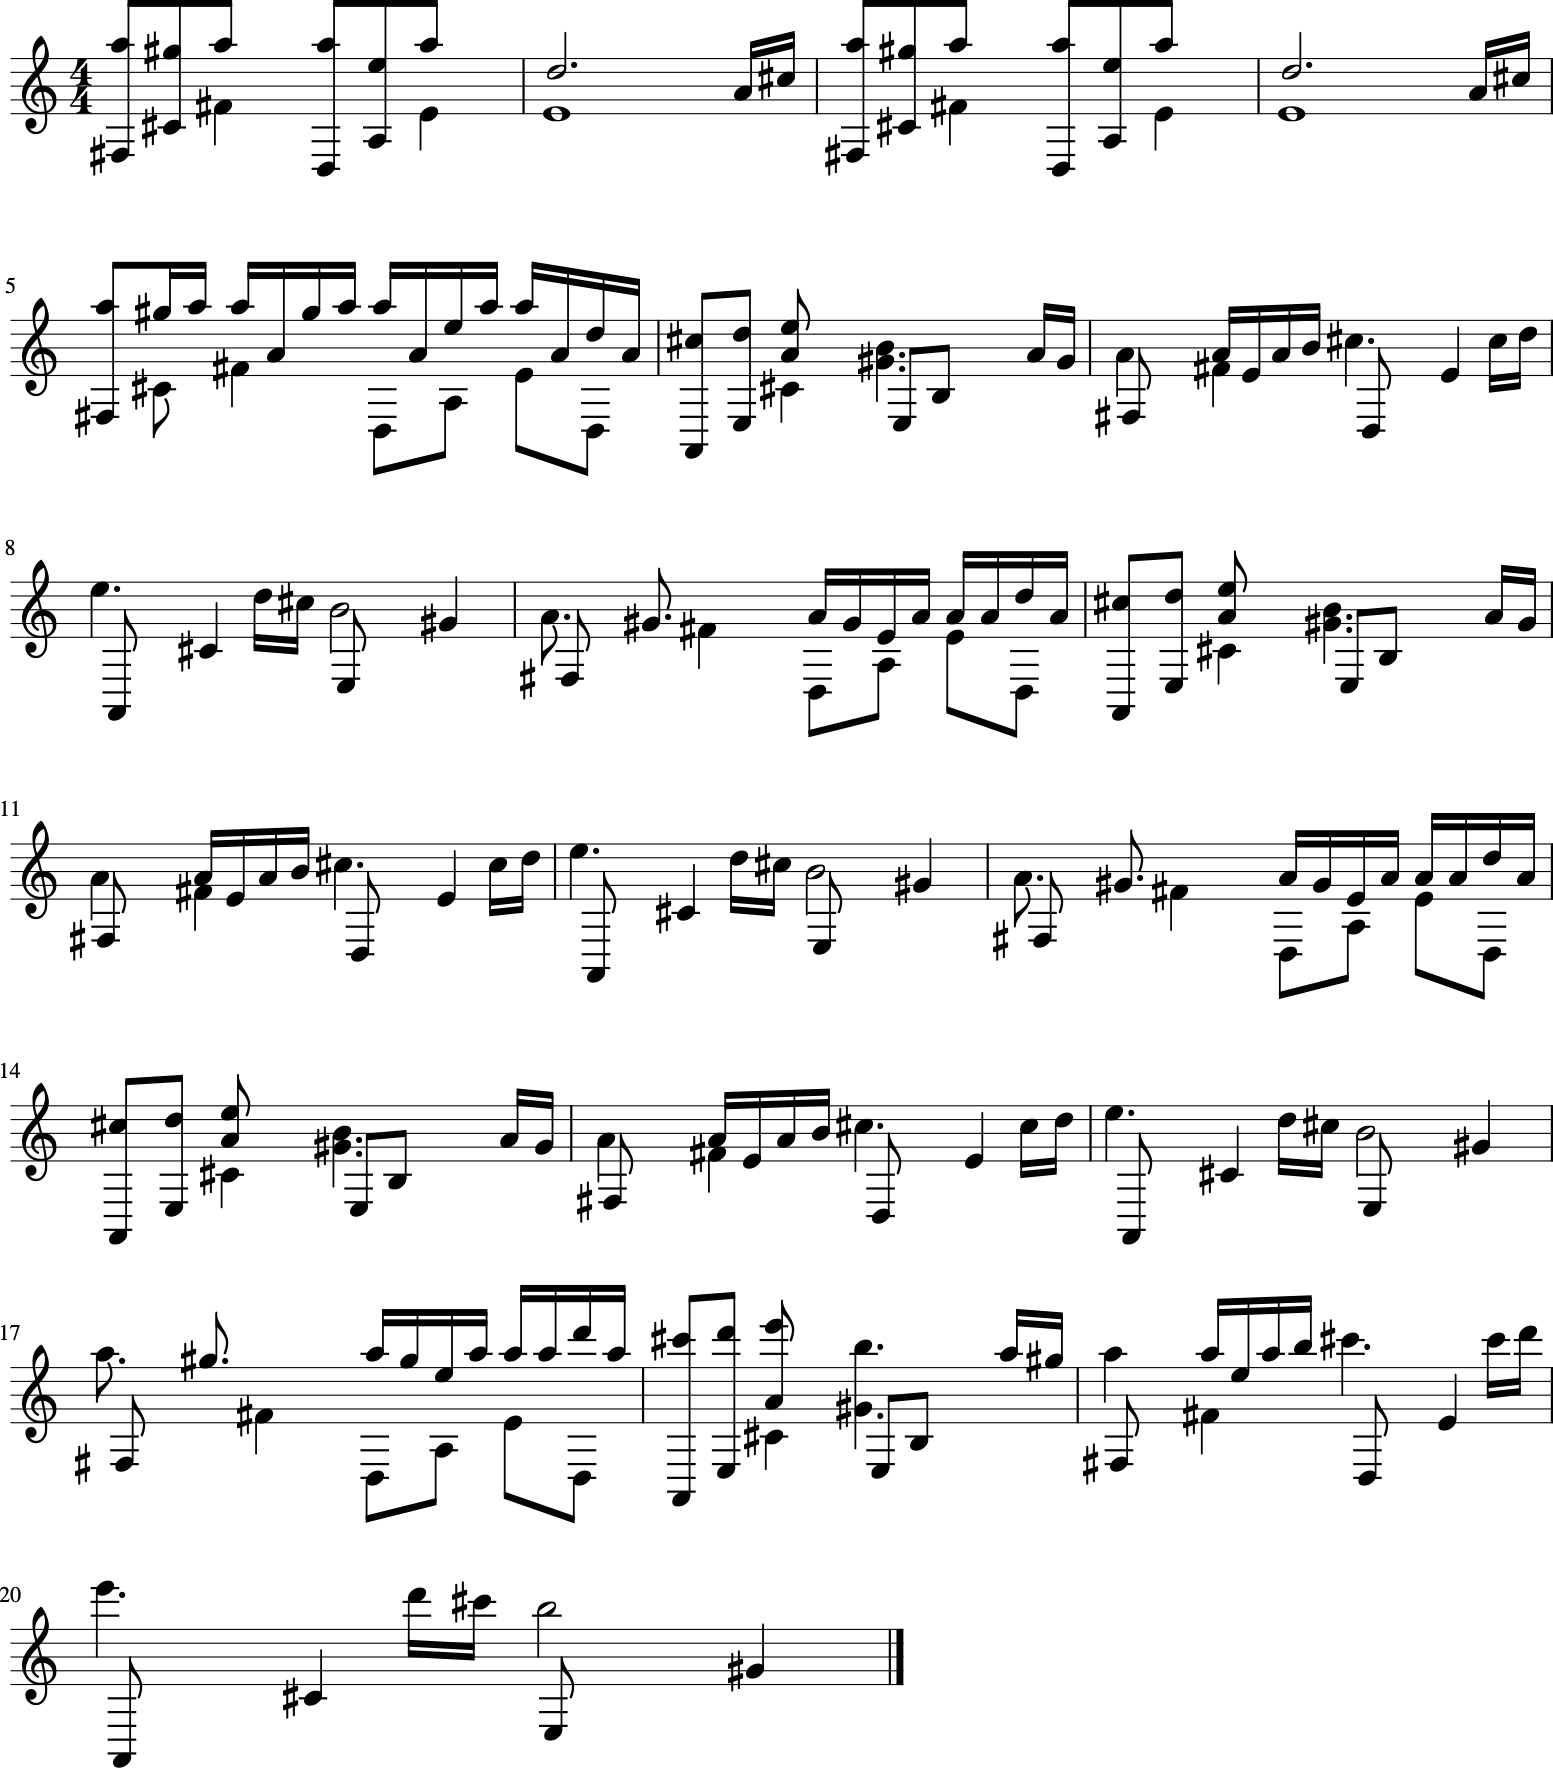

In [34]:
full_output = np.concatenate((seed,out), axis=0)
full_stream = npenc2stream(full_output)
full_stream.show()

In [35]:
full_stream.show('midi')

### Original

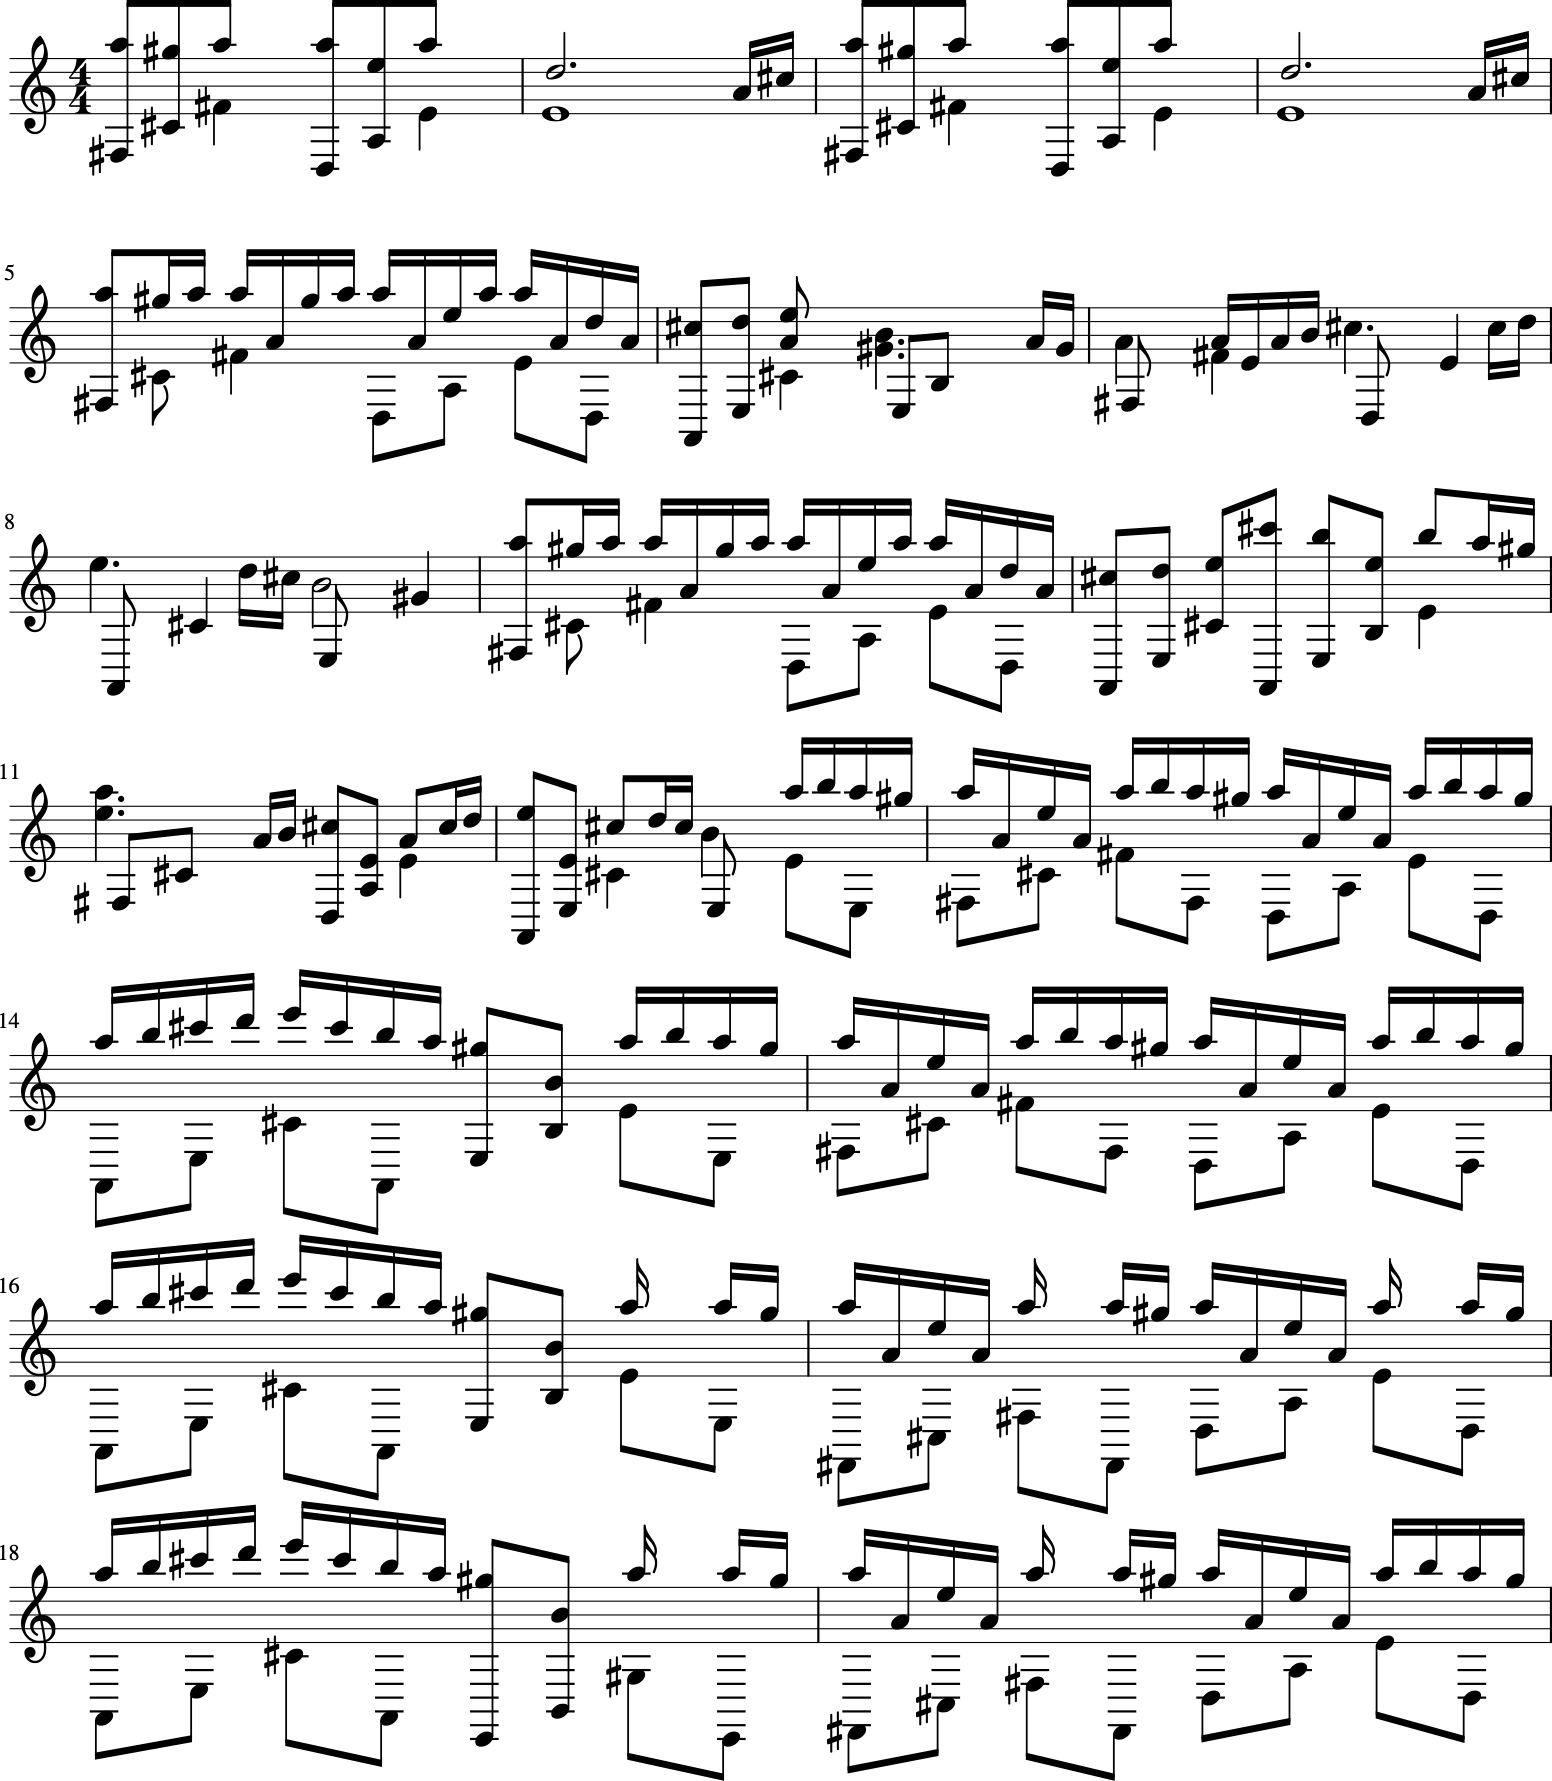

In [60]:
original_stream = npenc2stream(song_np)
original_stream.show()

In [62]:
original_stream.show('midi')